In [17]:
# Standard libraries
from itertools import chain

# Scientific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


# Spotify
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import spotify_credentials

# Utility functions
from helpers.helpers_pandas import jenks_filter

In [11]:
# read about scopes here: 
# https://developer.spotify.com/documentation/general/guides/authorization/scopes/#playlist-read-private

scope = "playlist-modify-private"
spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=spotify_credentials.client_ID, 
                                                client_secret= spotify_credentials.client_SECRET, 
                                                redirect_uri=spotify_credentials.redirect_url, 
                                                scope=scope,
                                                ),
                            requests_timeout=5,  # Tell Requests to stop waiting for a response after X seconds
                            retries=5,           # Total number of retries to allow
                            status_retries=3,    # Number of times to retry on bad status codes
                            backoff_factor=15,   # A backoff factor to apply between attempts after the second try
                        )

Load the data

In [19]:
# Load the data
audio_features = (
        "energy",
        "valence",
        "danceability",
        "loudness",
        "speechiness",
        "liveness",
        "tempo",
        "instrumentalness",
        "acousticness",
    )
other_audio_keys = (
        "key",
        "mode",
        "time_signature",
        "duration_ms",
    )
df = pd.read_pickle('../Data/pkl/03_spotify_data_clustered.pkl')[['spotify_id', 'cluster', 'genres', *audio_features, *other_audio_keys]]
enao_df = pd.read_pickle('../Data/pkl/02_everynoise_data.pkl')[['genre', 'x', 'y', 'color']]

In [20]:
nb_tracks = (df.groupby('cluster')['duration_ms'].count()).rename('nb tracks')
duraction = (df.groupby('cluster')['duration_ms'].sum()/3600000).round(1).rename('time (hours)')
clusters_overview = pd.concat([nb_tracks, duraction], axis=1)

tags = dict()

for cluster in df['cluster'].unique():
    mask = df['cluster'] == cluster
    all_genres = list(chain.from_iterable(df[mask]['genres'].to_list()))
    tags[cluster] = jenks_filter(all_genres, sort_by='count')

clusters_overview['main_genres'] = pd.Series(tags)
clusters_overview

,nb tracks,time (hours),main_genres
cluster,,,
0,612,48.1,"[electronica, downtempo, nu jazz, new french t..."
1,418,45.2,"[high vibe, shamanic, world fusion]"
2,378,40.0,"[organic house, organic electronic, ethnotroni..."
3,351,29.0,"[world, afropop, mande pop]"
4,106,7.5,"[chill beats, soundtrack, orchestral soundtrac..."
5,36,2.3,"[reggae, ska, rocksteady, roots reggae]"
6,5,0.5,[sound]
7,1,0.1,"[blackened hardcore, neo-crust]"
8,1,0.1,[white noise]


In [14]:
user_id = spotify.current_user()['id']

In [25]:
## For the first time, create a playlist for each main clusters
# Electro = spotify.user_playlist_create(user_id, 'Electronica', public=False, collaborative=False, description='Electronica')
# Shamanic_World_Fusion = spotify.user_playlist_create(user_id, 'Shamanic & World Fusion', public=False, collaborative=False, description='Shamanic & World Fusion and High Vibe')
# Organic_House_Electro = spotify.user_playlist_create(user_id, 'Organic House/Electro', public=False, collaborative=False, description='Organic House/Electro')
# World_Afropop = spotify.user_playlist_create(user_id, 'World & Afropop', public=False, collaborative=False, description='World and Afropop')
# Chill_Beats = spotify.user_playlist_create(user_id, 'Chill beats', public=False, collaborative=False, description='Chill beats')
# Reggae = spotify.user_playlist_create(user_id, 'Reggae', public=False, collaborative=False, description='Reggae')


In [32]:
Electro = spotify.user_playlist(user_id, playlist_id='4DCaAzlfmUPynFl32bM6BT')
Shamanic_World_Fusion = spotify.user_playlist(user_id, playlist_id='6VrFOL1veQt29BXPe15tgX')
Organic_House_Electro = spotify.user_playlist(user_id, playlist_id='1k0voWRjJmsUa6vfAVNurX')
World_Afropop = spotify.user_playlist(user_id, playlist_id='5ePXJftG8wcxXwkJ1g0xyt')
Chill_Beats = spotify.user_playlist(user_id, playlist_id='2Kxa0ThkYtFqzkt5JF2XmF')
Reggae = spotify.user_playlist(user_id, playlist_id='63QFM6EaHkgaer8AbqYj6P')



In [75]:
# TO BE DONE PROPERLY

cluster_dict = {
    0 : {'id': Electro['id'], 'title':Electro['name'], 'tracks':  df[df['cluster'] == 0]['spotify_id'].to_list()},
    1 : {'id': Shamanic_World_Fusion['id'], 'title':Shamanic_World_Fusion['name'], 'tracks':  df[df['cluster'] == 1]['spotify_id'].to_list()},
    2 : {'id': Organic_House_Electro['id'], 'title':Organic_House_Electro['name'], 'tracks':  df[df['cluster'] == 2]['spotify_id'].to_list()},
    3 : {'id': World_Afropop['id'], 'title':World_Afropop['name'], 'tracks':  df[df['cluster'] == 3]['spotify_id'].to_list()},
    4 : {'id': Chill_Beats['id'], 'title':Chill_Beats['name'], 'tracks':  df[df['cluster'] == 4]['spotify_id'].to_list()},
    5 : {'id': Reggae['id'], 'title':Reggae['name'], 'tracks':  df[df['cluster'] == 5]['spotify_id'].to_list()},
}

In [57]:
def chunk_list2(lst, max_items = 100):
    n = len(lst)
    results = []
    i = 0
    while i <= n // max_items:
        results.append(lst[i*max_items: (i+1)*max_items])
        i += 1
    return results

In [77]:
for k, clst in cluster_dict.items():
    for i, lst in enumerate(chunk_list2(clst['tracks'])):
        print(f"Addings songs {i*100}-{i*100+len(lst)} to playslit '{clst['title']}' (id='{clst['id']}')")
        # spotify.user_playlist_add_tracks(user_id, clst['id'], lst)  # UNCOMMENT TO ADD THE TRACKS
        

Addings songs 0-100 to playslit 'Chill beats' (id='2Kxa0ThkYtFqzkt5JF2XmF')
Addings songs 100-106 to playslit 'Chill beats' (id='2Kxa0ThkYtFqzkt5JF2XmF')


# Playlist creations

## ...

In [3]:
cluster = 0
temp_df = df[df['cluster'] == cluster][['spotify_id', *audio_features]].set_index('spotify_id')
temp_df.head()

,energy,valence,danceability,loudness,speechiness,liveness,tempo,instrumentalness,acousticness
spotify_id,,,,,,,,,
7ueP5u2qkdZbIPN2YA6LR0,0.436,0.2720,0.826,-9.583,0.0558,0.0964,119.051,0.61500,0.4410
0ytvsZOerGzUWfHXVT2Sgy,0.487,0.0454,0.655,-7.988,0.0330,0.2710,139.914,0.89700,0.0347
2usrT8QIbIk9y0NEtQwS4j,0.778,0.1520,0.617,-8.872,0.0270,0.1280,100.363,0.92500,0.4590
6UqRGwjwYL0stXbaodTxwo,0.831,0.4480,0.740,-7.321,0.0456,0.0769,121.034,0.00304,0.4440
3Ty7OTBNSigGEpeW2PqcsC,0.434,0.2070,0.510,-10.004,0.0361,0.0603,119.695,0.51600,0.1770


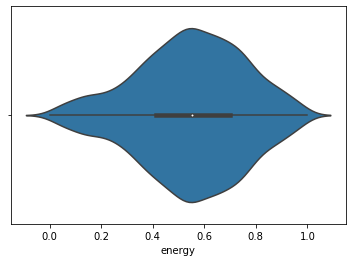

In [9]:
import seaborn as sns

ax = sns.violinplot(x="energy", data=df)

In [58]:
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(temp_df)
features_normal = pd.DataFrame(features_normal)
features_normal.columns = temp_df.columns
features_normal.index = temp_df.index
features_normal.head()

,energy,valence,danceability,loudness,speechiness,liveness,tempo,instrumentalness,acousticness
spotify_id,,,,,,,,,
0ytvsZOerGzUWfHXVT2Sgy,0.472487,0.016261,0.632418,0.788810,0.029412,0.256103,0.508212,0.910660,0.035111
2usrT8QIbIk9y0NEtQwS4j,0.773480,0.129557,0.590345,0.758741,0.011765,0.105640,0.257990,0.939086,0.464569
6UqRGwjwYL0stXbaodTxwo,0.828300,0.444149,0.726528,0.811497,0.066471,0.051873,0.388767,0.003086,0.449387
3WRQUvzRvBDr4AxMWhXc5E,0.511791,0.234775,0.776351,0.803503,0.055882,0.090909,0.197825,0.445685,0.677122
1hEh8Hc9lBAFWUghHBsCel,0.602813,0.347433,0.477414,0.774014,0.022059,0.443392,0.223587,0.205076,0.001477


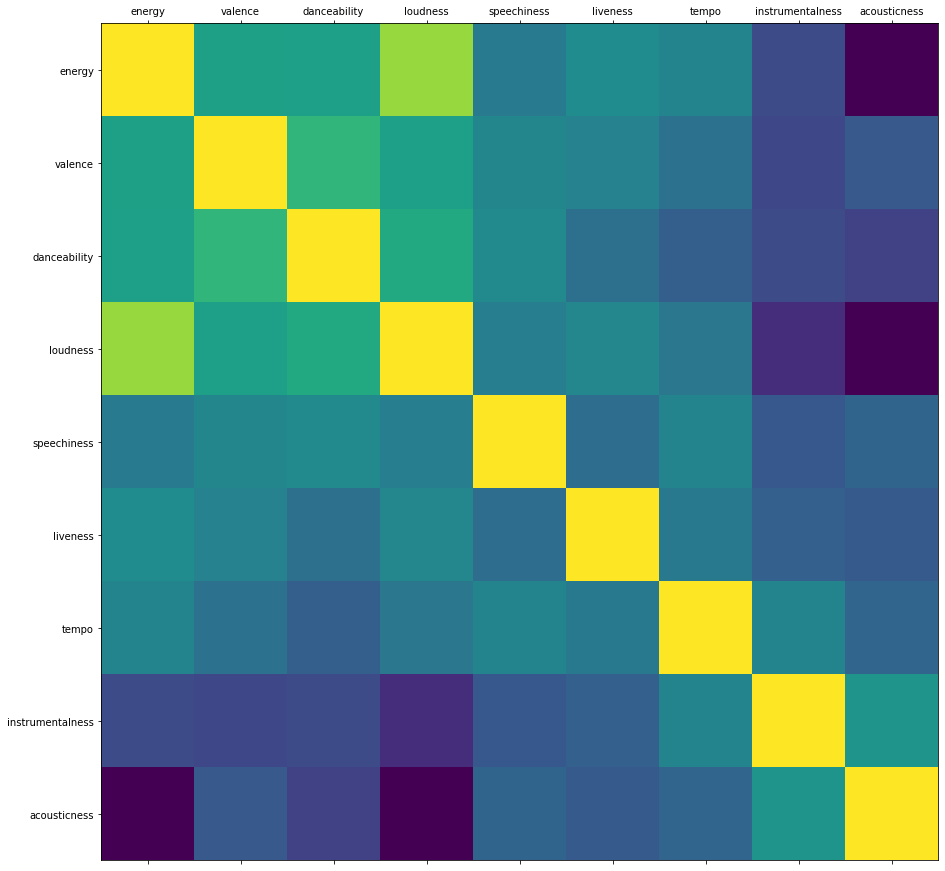

In [59]:
%matplotlib inline

corr_mat = features_normal.corr()
plt.figure(figsize=(15,15))
plt.matshow(corr_mat, fignum=1)
plt.yticks(np.arange(0, len(corr_mat.index), 1), corr_mat.index)
plt.xticks(np.arange(0, len(corr_mat.columns), 1), corr_mat.columns)
plt.show()

In [62]:
corr_mat.style.background_gradient()

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.